In [277]:
#These are the libraries you can use.  You may add any libraries directy related to threading if this is a direction
#you wish to go (this is not from the course, so it's entirely on you if you wish to use threading).  Any
#further libraries you wish to use you must email me, james@uwaterloo.ca, for permission.

from IPython.display import display, Math, Latex

import pandas as pd
import numpy as np
import numpy_financial as npf
import yfinance as yf
import matplotlib.pyplot as plt
import random
from datetime import datetime, timedelta

## Group Assignment
### Team Number: 05
### Team Member Names: James Begin, Jonathan Wen, Emily Qi
### Team Strategy Chosen: Market Meet

Disclose any use of AI for this assignment below (detail where and how you used it).  Please see the course outline for acceptable uses of AI.


## Contribution Declaration

The following team members made a meaningful contribution to this assignment:

Insert Names Here.

# Introduction 
The goal of the market "meet" portfolio is to match the returns of the average of the TSX60 and S&P500 indices as closely as possibly. To do this, we look at various indicators that can provide insight into a stock's ability to match market returns. Below are the factors we plan to take into account while constructing our portfolio:  
- Volume
- Price
- Market Cap
- (find a name for this) Score
- Earnings and Dividend Dates  

## Filtering
First, we ignore any delisted stocks, or non-US and Canadian Stocks, then filter by average monthly volume, minimum price, and market cap:
  



In [224]:
tickers = pd.read_csv('Tickers_Example.csv')
tickerlist = [tickers.columns[0]]
tickerlist += [i for i in tickers.iloc[:,0]]
startdate = '2024-01-01'
enddate = datetime.now().strftime('%Y-%m-%d')

stockdata = yf.download(tickerlist, start=startdate, end=enddate)
delisted = list(yf.shared._ERRORS.keys())
for i in delisted:
    tickerlist.remove(i)
    
exchangelist = ['NMS', 'NYQ', 'TOR']
minprice = 5
minvolume = 100000
mincap = 1000000000

for ticker in tickerlist:
    t = yf.Ticker(ticker)
    hist = t.history(start=startdate, end=enddate, period='1mo')
    inf = t.fast_info
    if ((t.get_history_metadata())['exchangeName'] not in exchangelist
            or hist['Volume'].mean() < minvolume 
            or hist['Close'].mean() < minprice
            or inf['market_cap'] > mincap):
        tickerlist.remove(ticker)    

Failed to get ticker 'MON' reason: Expecting value: line 1 column 1 (char 0)
[**                     5%                       ]  2 of 41 completed

2024-11-20 13:15:55.816269


[*********************100%***********************]  40 of 41 completed

8 Failed downloads:
['MON', 'AGN', 'RTN', 'CELG']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
['MO', 'PM', 'KO', 'AMZN']: ReadTimeout(ReadTimeoutError("HTTPSConnectionPool(host='query2.finance.yahoo.com', port=443): Read timed out. (read timeout=10)"))
[*********************100%***********************]  40 of 41 completed$BK: possibly delisted; no price data found  (1d 2024-01-01 -> 2024-11-20 13:15:55.816269)


KeyError: 'exchangeName'

## Earnings Dates and Dividends
The period surrounding Earnings Dates, and Dividend Dates typically bring about higher volatility as investors and speculators buy and sell, hoping to take advantage of upcoming news and guidance. Below we illustrate some of the effects of Earnings/Corporate Announcements on volatility.


<BarContainer object of 2 artists>

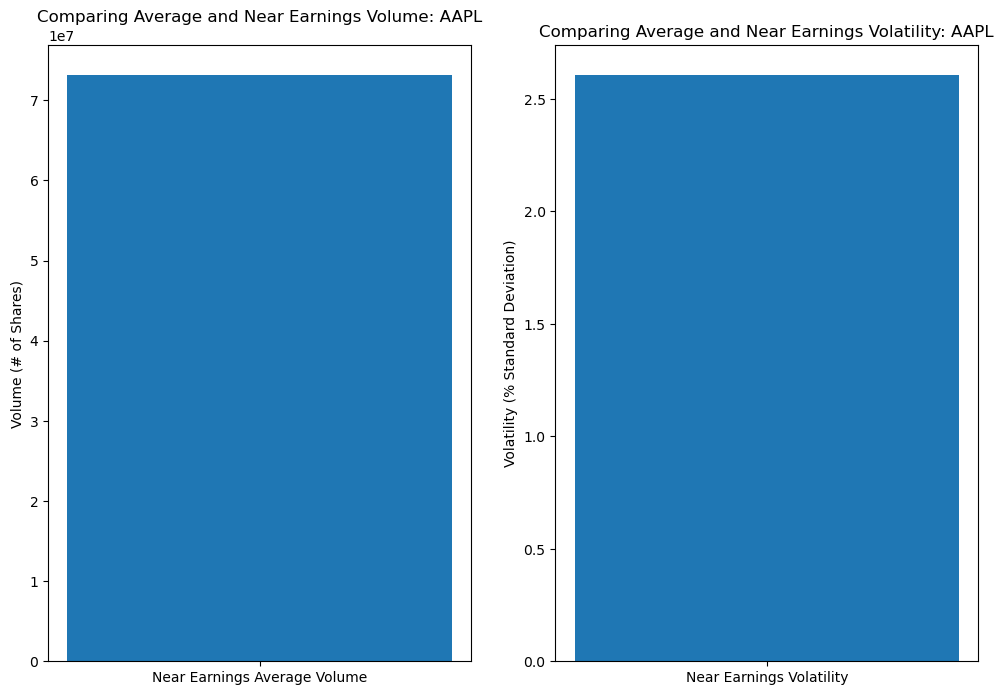

In [202]:
start1='2023-10-01'
end1='2023-11-01'
start2='2024-04-24'
end2='2024-05-05'
voldata = stockdata.loc[:, 'Volume']
plot1 = voldata.loc[start1:end1, 'AAPL'].mean()
plot2 = voldata.loc[start2:end2, 'AAPL'].mean()
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(12, 8)
ax1.set_title("Comparing Average and Near Earnings Volume: AAPL")
ax1.set_ylabel('Volume (# of Shares)')
ax1.bar(['Typical Average Volume', 'Near Earnings Average Volume'], [plot1, plot2])

plot3 = stockdata.loc[:, 'Adj Close'].loc[start1:end1, 'AAPL'].pct_change().std() * 100
plot4 = stockdata.loc[:, 'Adj Close'].loc[start2:end2, 'AAPL'].pct_change().std() * 100
ax2.set_title("Comparing Average and Near Earnings Volatility: AAPL")
ax2.set_ylabel("Volatility (% Standard Deviation)")
ax2.bar(['Typical Volatility', 'Near Earnings Volatility'], [plot3, plot4])

Notice the significant increase in both volume and volatility when AAPL is near earnings. This is what we want to avoid.

Considering that we want to minimize volatility in order to meet the market, we filter out any stocks that have upcoming earnings or dividend dates:

In [203]:
#fetch the current and cutoff dates
currdate = (datetime.now()).date()
cutoff = (currdate + timedelta(days=14))

for ticker in tickerlist:
    #fetch the relevant dates
    cal = yf.Ticker(ticker).calendar
    #ensure that the yfinance has the dates we want
    div = (cal['Ex-Dividend Date'] if 'Ex-Dividend Date' in cal.keys() else cutoff)
    earnings = (cal['Earnings Date'][1] if len(cal['Earnings Date']) > 1 else cal['Earnings Date'][0])
    #check if there are events in the near future
    if ((earnings > currdate) and (cutoff > earnings)) or ((div > currdate) and (cutoff > div)):
        tickerlist.remove(ticker)
        

## (Placeholder) Score
Beta is a measure of volatility of a security or portfolio compared to the market. A beta of 1.0 indicates that a stock follows the market's returns exactly. We can take the average of the two indices and calculate the beta for each stock. However, Beta is only a measure of how sensitive a stock's returns are compared to the market. We could have a stock with beta close to 1.0, but with a low correlation, which is not what we are after. Considering we want to match the market's returns exactly, we use correlation to identify the strength of a relationship with an index.  
  
We calculate the rolling correlation with each stock to the market average, as this ensures we capture how the correlation might have changed over past (especially in recent months). Then, we find both the average correlation and standard deviation of the correlation. Using this, we identify how often the stock is highly correlated (over a certain correlation threshold). The result of this metric is a percentage.  
  
Then, we calculate how stable the correlation is for each stock. This is done by dividing the average correlation by the standard deviation of the correlation. This ensures that we also take into account, not only high correlation, but high correlation that doesn't change often.  
  
To calculate the final score, we find the reciprocal of the distance of each beta to 1.0 (this ensures that bigger values are always better) and multiply it by the percent of time the stock is highly correlated. and by how stable the correlation is.  

  
We can calculate beta using the formula (Covariance(Individual Returns, Market Returns)) / (Variance(Market Returns))

In [211]:
indices = pd.DataFrame()
indices['tsxprice'] = yf.download('XIU.TO', start=startdate, end=enddate)['Adj Close']
indices['spprice'] = yf.download('SPY', start=startdate, end=enddate)['Adj Close']

closedata = stockdata.loc[:, 'Adj Close']

tsxpct = indices['tsxprice'].pct_change(fill_method=None)
sppct = indices['spprice'].pct_change(fill_method=None)
avgpct = (tsxpct + sppct) / 2
tsxvar = tsxpct.var()
spvar = sppct.var()
avgvar = (tsxvar + spvar) / 2
scores = {}

#calculate score for each stock
for ticker in tickerlist:
    #prevent any mismatched indexes
    common = closedata[ticker].index.intersection(indices.index)
    
    closepct = closedata.loc[common, ticker].pct_change(fill_method=None)
    
    #calculate beta with respect to TSX and S&P Average
    beta = closepct.cov(sppct) / spvar
    
    #print(beta)
    #calculate weekly rolling correlation (7 day window)
    rolling_correlation = closepct.rolling(window=14).corr(sppct)
    correlation_std = rolling_correlation.std()
    correlation_mean = rolling_correlation.mean()
    #find how often each stock is strongly correlated
    correlation_pct = (rolling_correlation > 0.5).mean()
    #find how consistent the correlation is
    consistency = correlation_mean / (correlation_std if correlation_std != 0 else 0.0001)
    #calculate score
    
    print(ticker, 1 / (1 + abs(beta-1.0)), correlation_mean, correlation_pct, consistency)
    score = correlation_pct * (1 / (1 + abs(beta - 1.0))) * consistency
    
    scores[ticker] = score



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

ABBV 0.5423343429963642 0.20596779073529317 0.08133971291866028 0.8436373825821235
ACN 0.7423706003279127 0.48018757599314377 0.3014354066985646 1.9762484066043506
AMZN 0.6322080196774303 0.7408888247171436 0.6698564593301436 6.183521207473586
BA 0.8944794531853495 0.29300786029157566 0.20095693779904306 0.8162036233608925
BB.TO 0.6660670405311974 0.4734439589560948 0.3588516746411483 1.7106724972066956
BK 0.7099005288275945 0.458708363521078 0.3492822966507177 1.6702447932249986
BMY 0.5472627099482268 0.1211299559413407 0.0430622009569378 0.5224356275098191
CAT 0.847844602073363 0.5958987409614054 0.5406698564593302 3.255385236848997
LMT 0.46902327467959964 -0.10702852034202504 0.004784688995215311 -0.4284859070963192
MRK 0.5724486140789873 0.18477966612070743 0.07655502392344497 0.6876670620591679
PFE 0.5803517662465841 0.21243379119047456 0.11004784688995216 0.7843234430626592
PM 0.5322285910383322 0.14717137290358437 0.08133971291866028 0.5169335167490717
QCOM 0.46071066930590254 0

The highest score stocks are: 
AMZN 2.618650897652812
CAT 1.4922816769506528
SHOP.TO 0.5764229252780725
QCOM 0.5630267847631437
ACN 0.44223851248086615
BK 0.4141466953334128
BB.TO 0.40888369648298206
UPS 0.2872494039225414
TD.TO 0.1494551416167728
BA 0.14671411277461047
PFE 0.05009196361851856
ABBV 0.03721564562376756
MRK 0.03013619572237624
PM 0.022378734706973328
BMY 0.01231189395005136
UNH 0.001479860497436106
LMT -0.0009615782933032264


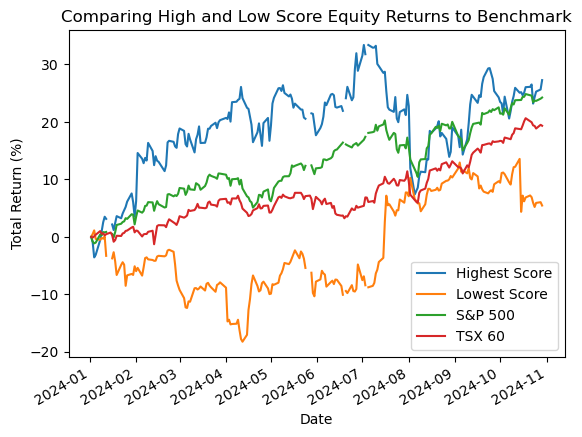

In [219]:
scores_sorted = []
print('The highest score stocks are: ')
for t in sorted(scores, key=scores.get, reverse=True):
    scores_sorted.append(t)
    print(t, scores[t])

fig, ax = plt.subplots()
ax.set_title("Comparing High and Low Score Equity Returns to Benchmark")
ax.set_xlabel("Date")
ax.set_ylabel("Total Return (%)")


ax.plot(closedata[scores_sorted[0]] / (closedata[scores_sorted[0]]).values[0] * 100 - 100, label='Highest Score')
ax.plot(closedata[scores_sorted[-2]] / (closedata[scores_sorted[-2]]).values[0] * 100 - 100, label='Lowest Score')
ax.plot(indices['spprice'] / indices['spprice'].values[0] * 100 - 100, label='S&P 500')
ax.plot(indices['tsxprice'] / indices['tsxprice'].values[0] * 100 - 100, label='TSX 60')
fig.autofmt_xdate()
ax.legend(loc='best')



This plot aims to show the effectiveness of our score in finding "market matching" stocks. Notice, that just by observation, the highest score returns match both of the indices much better than the lowest score stock.

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Ticker
XIU.TO    0.00004
dtype: float64


In [274]:
num_stocks = 16
#generate equally spaced weights for each of our 16 stocks
weights = np.linspace(9, 3.5, num_stocks)
totalc = 1000000

Portfolio_Final = pd.DataFrame()
Portfolio_Final['Ticker'] = scores_sorted[:num_stocks]
Portfolio_Final['Weight'] = weights
pricelist = []
sharelist = []
currlist = []
valuelist = []
#get usdcad exchange rate
usdcad = yf.Ticker("USDCAD=X").history(period='1d', start='2024-11-18', end='2024-11-19')['Close'].iloc[0]

for ticker in range(num_stocks):
    
    cash = weights[ticker]*totalc
    t = yf.Ticker(scores_sorted[ticker])
    p = (closedata.loc[:, scores_sorted[ticker]]).values[-1]

    pricelist.append(p)
    
    #if the stock is listed in USD, 
    if (t.get_history_metadata())['exchangeName'] != 'TOR':
        currlist.append('USD')
        cadp = p * usdcad
        num_shares = cash / cadp
        if 0.001 * num_shares < 3.95:
            cadp += 0.001
            num_shares = cash/cadp
            sharelist.append(num_shares)
            value = num_shares * cadp - 0.001
        else:
            num_shares = (cash-3.95)/cadp
            sharelist.append(num_shares)
            value = num_shares * cadp
    else:
        currlist.append('CAD')
        num_shares = cash / p

        if 0.001 * num_shares < 3.95:
            p += 0.001
            num_shares = cash/p
            sharelist.append(num_shares)
            value = num_shares * (p-0.001)
        else:
            num_shares = (cash-3.95)/p
            sharelist.append(num_shares)
            value = num_shares * p
    
    
    valuelist.append(value)

Portfolio_Final['Price'] = pricelist
Portfolio_Final['Shares'] = sharelist
Portfolio_Final['Value'] = valuelist
Portfolio_Final['Currency'] = currlist
Portfolio_Final.index = Portfolio_Final.index + 1
print(f"Total Portfolio Value: ${Portfolio_Final['Value'].sum()}")
print(f"Total Portfolio Weight: {Portfolio_Final['Weight'].sum()}")

Total Portfolio Value: $99999936.8
Total Portfolio Weight: 100.0


In [276]:
Stocks_Final = Portfolio_Final[['Ticker', 'Shares']]
Stocks_Final.to_csv('Stocks_Group_42.csv')